Key Techniques:


*   Apply Data Segmentation, Features Extraction
*   Apply better LSTM
*   Apply Class Weight Technique



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd Colab

/content/drive/MyDrive/Colab


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from scipy.stats import zscore
from scipy.spatial.distance import euclidean
from scipy.interpolate import interp1d
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import joblib

In [ ]:
# Function to calculate total activity (sum of standard deviation)
def total_activity(segment):
    return np.sum(np.std(segment, axis=0))

# Function to calculate position offset (Euclidean distance from robust mean)
def position_offset(segment, standing_mean):
    mean = np.mean(segment, axis=0)
    return euclidean(mean, standing_mean)

# Function to calculate the number of mean crossings
def mean_crossings(segment):
    crossings = ((segment[:-1] * segment[1:]) < 0).sum(axis=0)
    return np.sum(crossings)

# Function to interpolate ecdf
def interpolate_ecdf(segment, n_points=7):
    ecdf_values = []
    for i in range(segment.shape[1]):
        sorted_data = np.sort(segment[:, i])
        ecdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)
        inv_ecdf = interp1d(ecdf, sorted_data, bounds_error=False, fill_value="extrapolate")
        quantiles = np.linspace(0, 1, n_points)
        ecdf_values.extend(inv_ecdf(quantiles))
    return ecdf_values

# Function to extract features from a segment
def extract_features(segment, standing_mean):
    features = []
    # Accelerometer features
    accel_features = [
        total_activity(segment[:, :3]),
        position_offset(segment[:, :3], standing_mean[:3]),
        mean_crossings(segment[:, :3])
    ]
    accel_features.extend(np.mean(segment[:, :3], axis=0))
    accel_features.extend(interpolate_ecdf(segment[:, :3]))

    # Gyroscope features
    gyro_features = [
        total_activity(segment[:, 3:]),
        position_offset(segment[:, 3:], standing_mean[3:]),
        mean_crossings(segment[:, 3:])
    ]
    gyro_features.extend(np.mean(segment[:, 3:], axis=0))
    gyro_features.extend(interpolate_ecdf(segment[:, 3:]))

    features.extend(accel_features)
    features.extend(gyro_features)
    return features

# Data segmentation
def segment_data(df, window_size=200, overlap=0.5, behavior_col='Annotated_Behavior'):
    segments = []
    labels = []
    step = int(window_size * (1 - overlap))
    standing_mean = np.mean(df[df[behavior_col] == 'Standing'].iloc[:, :-1], axis=0)

    # Save the standing mean
    np.save('./standing_mean.npy', standing_mean)

    for start in range(0, len(df) - window_size + 1, step):
        end = start + window_size
        segment = df.iloc[start:end, :-1].values
        label = df.iloc[start:end][behavior_col].mode()[0]
        label_count = df.iloc[start:end][behavior_col].value_counts(normalize=True)
        if label_count[label] >= 0.75:
            features = extract_features(segment, standing_mean)
            segments.append(features)
            labels.append(label)
    np.save('segments.npy', segments)
    np.save('labels.npy', labels)
    return np.array(segments), np.array(labels)

# Prepare the dataset
df = pd.read_csv('./processed_data_back.csv')

# Segment data and extract features
X, y = segment_data(df)

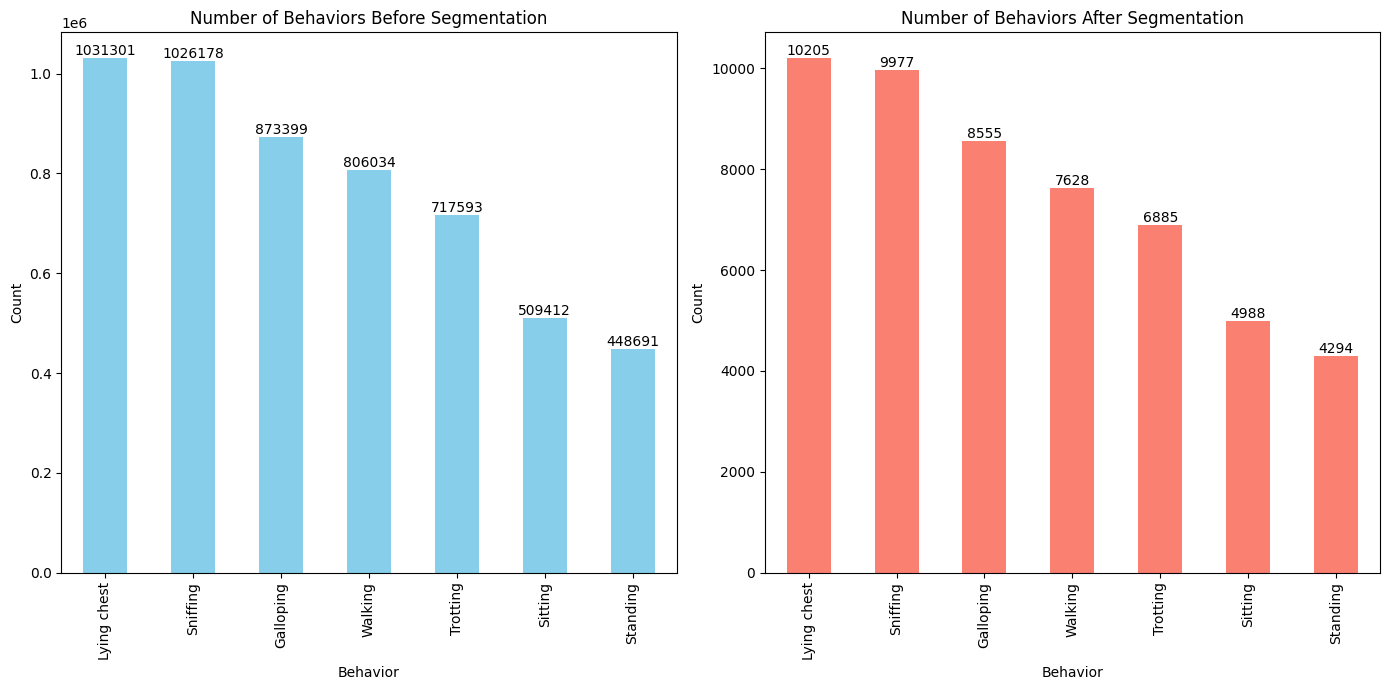

In [ ]:
import matplotlib.pyplot as plt

# Count the number of behaviors before segmentation
behavior_counts_before = df['Annotated_Behavior'].value_counts()

# Count the number of behaviors after segmentation
behavior_counts_after = pd.Series(y).value_counts()

# Plotting the bar charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

# Bar chart for behavior counts before segmentation
behavior_counts_before.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Number of Behaviors Before Segmentation')
axes[0].set_xlabel('Behavior')
axes[0].set_ylabel('Count')

# Add count labels on top of each bar
for i, v in enumerate(behavior_counts_before):
    axes[0].text(i, v, str(v), ha='center', va='bottom')

# Bar chart for behavior counts after segmentation
behavior_counts_after.plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Number of Behaviors After Segmentation')
axes[1].set_xlabel('Behavior')
axes[1].set_ylabel('Count')

# Add count labels on top of each bar
for i, v in enumerate(behavior_counts_after):
    axes[1].text(i, v, str(v), ha='center', va='bottom')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
# Normalize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Reshape input for LSTM [samples, time steps, features]
X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

In [ ]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [ ]:
# One-hot encode the labels
from tensorflow.keras.utils import to_categorical
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [ ]:
X_train.shape[1]
X_train.shape[2]

Epoch 1/15
526/526 [==============================] - 40s 52ms/step - loss: 0.8222 - accuracy: 0.6462 - val_loss: 0.4234 - val_accuracy: 0.8395
Epoch 2/15
526/526 [==============================] - 24s 46ms/step - loss: 0.4086 - accuracy: 0.8550 - val_loss: 0.3557 - val_accuracy: 0.8802
Epoch 3/15
526/526 [==============================] - 22s 42ms/step - loss: 0.3639 - accuracy: 0.8737 - val_loss: 0.3219 - val_accuracy: 0.8909
Epoch 4/15
526/526 [==============================] - 26s 49ms/step - loss: 0.3170 - accuracy: 0.8881 - val_loss: 0.2663 - val_accuracy: 0.9083
Epoch 5/15
526/526 [==============================] - 24s 46ms/step - loss: 0.2780 - accuracy: 0.9027 - val_loss: 0.2321 - val_accuracy: 0.9244
Epoch 6/15
526/526 [==============================] - 25s 47ms/step - loss: 0.2455 - accuracy: 0.9168 - val_loss: 0.2113 - val_accuracy: 0.9315
Epoch 7/15
526/526 [==============================] - 26s 50ms/step - loss: 0.2139 - accuracy: 0.9284 - val_loss: 0.1943 - val_accuracy:

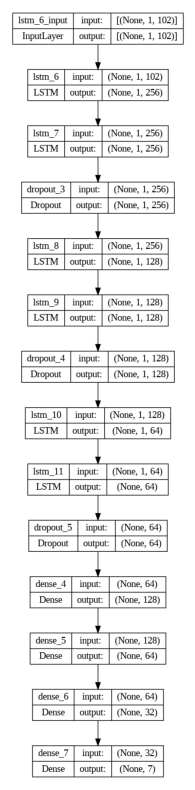

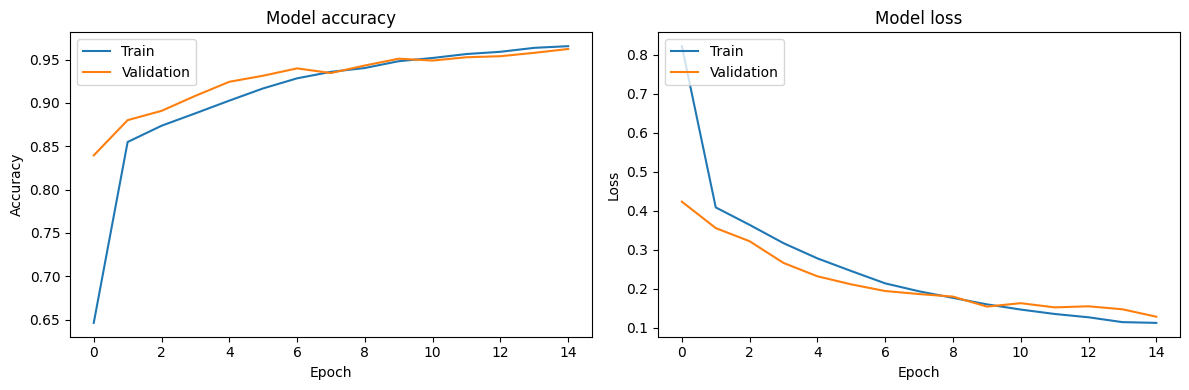

In [ ]:
# New
# Define the LSTM model
model = Sequential()

# First LSTM layer
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.5))

# Second LSTM layer
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))

# Third LSTM layer
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dropout(0.5))

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Output layer
model.add(Dense(y_train_categorical.shape[1], activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(np.argmax(y_train_categorical, axis=1)),
                                                  y=np.argmax(y_train_categorical, axis=1))

# Convert class_weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

# Train the model with class weights
history = model.fit(X_train, y_train_categorical,
                    epochs=15,
                    batch_size=64,
                    validation_split=0.2,
                    class_weight=class_weight_dict)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_categorical)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Visualize the model architecture
plot_model(model, to_file='lstm_model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the architecture image
img = plt.imread('lstm_model_architecture.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

329/329 [==============================] - 5s 16ms/step


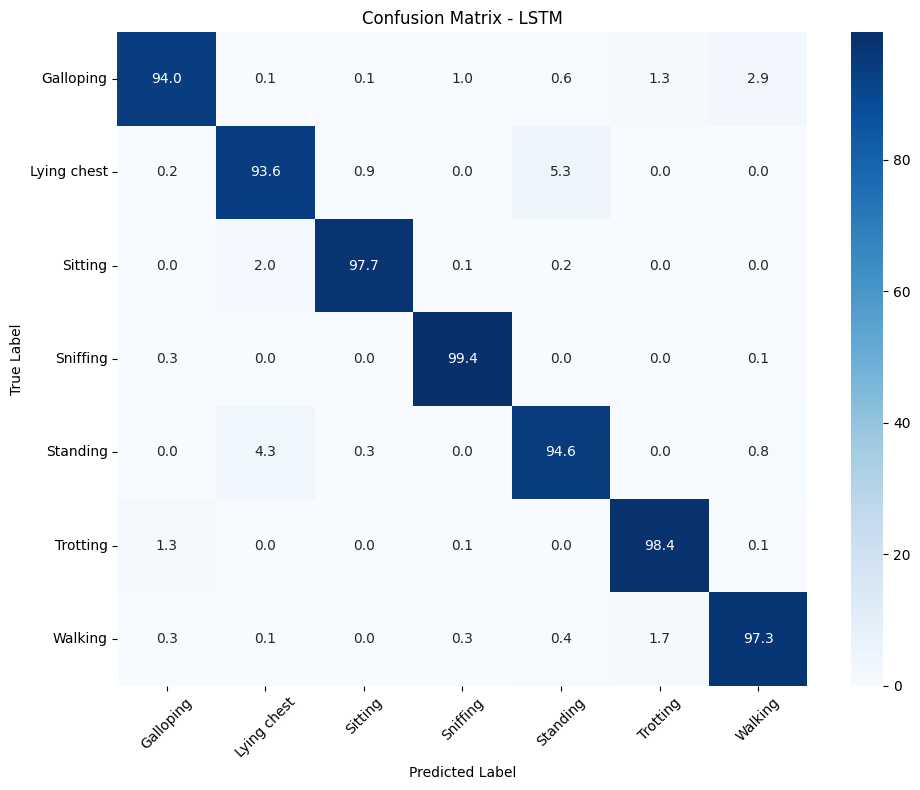

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
import joblib
# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Normalize the confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Define class names
class_names = label_encoder.classes_

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".1f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - LSTM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Save the model
model.save('dog_behavior_classifier.keras')
# Save the label encoder
joblib.dump(label_encoder, 'label_encoder.pkl')
# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [ ]:
import numpy as np
import pandas as pd
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import euclidean
from scipy.interpolate import interp1d
import time

# Load the pre-trained model
model = load_model('dog_behavior_classifier.keras')
# Load the saved scaler and label encoder
scaler = joblib.load('scaler.pkl')
label_encoder = joblib.load('label_encoder.pkl')

# Function definitions for feature extraction (same as in training)
def total_activity(segment):
    return np.sum(np.std(segment, axis=0))

def position_offset(segment, standing_mean):
    mean = np.mean(segment, axis=0)
    return euclidean(mean, standing_mean)

def mean_crossings(segment):
    crossings = ((segment[:-1] * segment[1:]) < 0).sum(axis=0)
    return np.sum(crossings)

def interpolate_ecdf(segment, n_points=7):
    ecdf_values = []
    for i in range(segment.shape[1]):
        sorted_data = np.sort(segment[:, i])
        ecdf = np.arange(1, len(sorted_data)+1) / len(sorted_data)
        inv_ecdf = interp1d(ecdf, sorted_data, bounds_error=False, fill_value="extrapolate")
        quantiles = np.linspace(0, 1, n_points)
        ecdf_values.extend(inv_ecdf(quantiles))
    return ecdf_values

def extract_features(segment, standing_mean):
    features = []
    accel_features = [
        total_activity(segment[:, :3]),
        position_offset(segment[:, :3], standing_mean[:3]),
        mean_crossings(segment[:, :3])
    ]
    accel_features.extend(np.mean(segment[:, :3], axis=0))
    accel_features.extend(interpolate_ecdf(segment[:, :3]))

    gyro_features = [
        total_activity(segment[:, 3:]),
        position_offset(segment[:, 3:], standing_mean[3:]),
        mean_crossings(segment[:, 3:])
    ]
    gyro_features.extend(np.mean(segment[:, 3:], axis=0))
    gyro_features.extend(interpolate_ecdf(segment[:, 3:]))

    features.extend(accel_features)
    features.extend(gyro_features)
    return features

# Assume we have access to the mean of the standing behavior
# This should be precomputed from the training dataset
standing_mean = np.load('/content/drive/MyDrive/Colab Notebooks/Đồ Án Tốt Nghiệp/LSTM Algorithm/Train For All Sensor/standing_mean.npy')  # Replace with actual path to standing mean

# Initialize the label encoder with the same classes used in training
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['Walking', 'Sniffing', 'Sitting', 'Trotting', 'Lying chest', 'Standing', 'Galloping'])

# Real-time data processing
window_size = 200
overlap = 0.5
buffer = []
start_time = None  # Start time for the first data point

def process_real_time_data(new_data_point):
    global buffer, start_time

    # Append new data point to the buffer
    buffer.append(new_data_point)

    if len(buffer) == 1:
        # Record the start time when the first data point is received
        start_time = time.time()

    if len(buffer) >= window_size:
        # Extract a window segment
        segment = np.array(buffer[-window_size:])


        # Extract features from the segment
        features = extract_features(segment, standing_mean)
        features = scaler.transform([features])  # Scale the features
        features = features.reshape(1, 1, -1)  # Reshape for LSTM


        # Record start time for prediction
        prediction_start_time = time.time()

        # Predict behavior
        prediction = model.predict(features)

        # Record end time for prediction
        prediction_end_time = time.time()

        # Calculate prediction time
        prediction_time = prediction_end_time - prediction_start_time
        print(prediction_time)
        predicted_label = np.argmax(prediction, axis=1)
        predicted_behavior = label_encoder.inverse_transform(predicted_label)

        # Calculate total time from first data point to prediction
        total_time = prediction_end_time - start_time

        # Output the prediction and times taken
        print(f'Predicted Behavior: {predicted_behavior[0]} - Prediction Time: {prediction_time:.4f} seconds - Total Time: {total_time:.4f} seconds')

        # Maintain buffer for overlap
        buffer = buffer[int(window_size * (1 - overlap)):]

# Example function to simulate real-time data reception
def receive_real_time_data():
    # Replace this function with actual data acquisition from sensors
    while True:
        # Simulate receiving a new data point
        new_data_point = np.random.rand(12)  # Replace with actual sensor data
        process_real_time_data(new_data_point)
        time.sleep(0.01)  # Simulate real-time delay

# Start receiving and processing real-time data
receive_real_time_data()

1/1 [==============================] - 3s 3s/step
Predicted Behavior: Trotting - Prediction Time: 2.6365 seconds - Total Time: 4.6689 seconds
1/1 [==============================] - 0s 26ms/step
Predicted Behavior: Trotting - Prediction Time: 0.0883 seconds - Total Time: 5.7820 seconds
1/1 [==============================] - 0s 24ms/step
Predicted Behavior: Trotting - Prediction Time: 0.0783 seconds - Total Time: 6.8853 seconds
1/1 [==============================] - 0s 24ms/step
Predicted Behavior: Trotting - Prediction Time: 0.0875 seconds - Total Time: 7.9968 seconds
1/1 [==============================] - 0s 26ms/step
Predicted Behavior: Trotting - Prediction Time: 0.0822 seconds - Total Time: 9.1047 seconds
1/1 [==============================] - 0s 25ms/step
Predicted Behavior: Trotting - Prediction Time: 0.0839 seconds - Total Time: 10.2137 seconds
1/1 [==============================] - 0s 27ms/step
Predicted Behavior: Trotting - Prediction Time: 0.0961 seconds - Total Time: 11.3362 

KeyboardInterrupt: 

In [ ]:
# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Generate classification report
report = classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_)
print(report)

329/329 [==============================] - 5s 15ms/step
              precision    recall  f1-score   support

     Walking       0.98      0.94      0.96      1687
    Sniffing       0.97      0.94      0.95      2057
     Sitting       0.98      0.98      0.98      1016
    Trotting       0.99      0.99      0.99      2037
 Lying chest       0.87      0.95      0.90       870
    Standing       0.97      0.98      0.97      1345
   Galloping       0.96      0.97      0.97      1495

    accuracy                           0.96     10507
   macro avg       0.96      0.96      0.96     10507
weighted avg       0.97      0.96      0.96     10507



In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
# Calculate average metrics
average_accuracy = accuracy_score(y_true, y_pred_classes)
average_precision = precision_score(y_true, y_pred_classes, average='macro')
average_recall = recall_score(y_true, y_pred_classes, average='macro')
average_f1_score = f1_score(y_true, y_pred_classes, average='macro')

print(f'Average Accuracy: {average_accuracy * 100:.2f}%')
print(f'Average Precision: {average_precision * 100:.2f}%')
print(f'Average Recall: {average_recall * 100:.2f}%')
print(f'Average F1-Score: {average_f1_score * 100:.2f}%')

Average Accuracy: 96.42%
Average Precision: 95.80%
Average Recall: 96.44%
Average F1-Score: 96.08%


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from scipy.spatial.distance import euclidean
from scipy.interpolate import interp1d
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import joblib
import scipy
import tensorflow as tf
import keras
import sklearn
# Check versions
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("SciPy version:", scipy.__version__)
print("Keras version:", keras.__version__)
print("TensorFlow version:", tf.__version__)
print("Joblib version:", joblib.__version__)
print("Scikit-learn version:", sklearn.__version__)